This notebook helps view Hi-C files in the .cool format. 

It is based on cooler_api.ipynb on the open2c github: 

https://github.com/open2c/cooler-binder/blob/master/cooler_api.ipynb

In [1]:
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py
import matplotlib as mpl
import ipywidgets as widgets

import cooler

In [2]:
# activate inline plotting
%matplotlib inline

In [3]:
#You can change the end to 1000 or 50000 to select different ?resolutions?
filepath = '/Users/douglas/Documents/Features Transfer/store Hi-C/JJ10_11_17_18.wo3kbCisTransHom.50000.cool'
c = cooler.Cooler(filepath)

### Full Hi-C Map

/var/folders/yg/xmt_zsl154zd8l51xlg5s_s40000gn/T/ipykernel_2949/898309178.py:8: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(arr), cmap='YlOrRd')


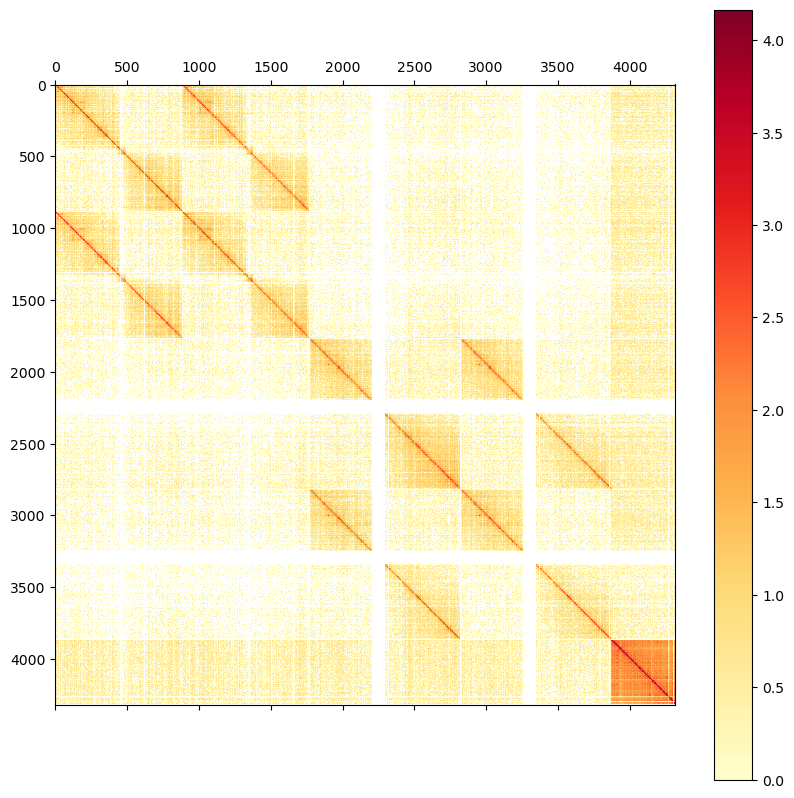

In [4]:
c.matrix()
arr = c.matrix(balance=False)[0:4317, 0:4317]
mat = c.matrix(balance=False, sparse=True)[0:4317, 0:4317]
arr = mat.toarray()#fill in lower triangle

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='YlOrRd')

fig.colorbar(im)

### Tables About the Input Hi-C Map

In [5]:
# 057 = maternal
# 439 = paternal
# length units are base pairs
c.chroms()[:]

,name,length
0,chr2L_057,23011544
1,chr2R_057,21146708
2,chr2L_439,23011544
3,chr2R_439,21146708
4,chr3L_057,24543557
5,chr3R_057,27905053
6,chr3L_439,24543557
7,chr3R_439,27905053
8,chrX_057,22422827


In [6]:
for name in c.chromnames:
    print(name,'   ', c.extent(name))
    
#name    (start_index, stop_index)

chr2L_057     (0, 461)
chr2R_057     (461, 884)
chr2L_439     (884, 1345)
chr2R_439     (1345, 1768)
chr3L_057     (1768, 2259)
chr3R_057     (2259, 2818)
chr3L_439     (2818, 3309)
chr3R_439     (3309, 3868)
chrX_057     (3868, 4317)


### Chr2 Trans Hi-C Map

In [8]:
# Explore the chr2 trans Hi-C diagonal.

d_0 = 50 #bins along diagonal of Hi-C map close-up.

@widgets.interact #refreshes d automatically
def close_HiC(d = (0,884-d_0)):
    #Pat=439 varies by row, Mat=057 varies by column.
    arr2 = c.matrix(balance=False)[884+d:884+d_0+d,d:d_0+d]
    mat2 = c.matrix(balance=False, sparse=True)[884+d:884+d_0+d,d:d_0+d]
    arr2 = mat2.toarray()#fill in lower triangle
    fig2 = plt.figure(figsize=(10, 10))
    ax2 = fig2.add_subplot(111)
    im2 = ax2.matshow(np.log10(arr2), cmap='YlOrRd')
    fig2.colorbar(im2)

interactive(children=(IntSlider(value=417, description='d', max=834), Output()), _dom_classes=('widget-interac…

# Filler Text to Prevent Annoying Scrolling Behavior When Above Cell Refreshes.
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>